In [1]:
import sys, os, re, gzip, json, random, math

import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

import librosa
import librosa.display

import soundfile as sf

%matplotlib inline

In [4]:
#!{sys.executable} -m pip install librosa

In [15]:
data_path = '../data'

myspace_path = '%s/myspace_mp3s' % data_path
metadata_path = '%s/metadata.json.gz' % myspace_path
genre_map_path = '%s/genre_map.pkl' % myspace_path

features_path = '%s/audio_features' % data_path
melspec_path = '%s/melspec' % features_path

model_path = 'lstm.model'
num_gpus = torch.cuda.device_count()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
def get_samples(melspec_path, sample_width, genres, max_samples):
    samples = []
    per_genre = max_samples//len(genres)
    
    for genre in genres:
        genre_path = '%s/%s' % (melspec_path, genre)
        
        fns = [fn for fn in os.listdir(genre_path) if fn.endswith('.npy')]
        random.shuffle(fns)
        fns = fns[:20]
        per_file = per_genre//len(fns)
        
        for fn in fns:
            fp = '%s/%s' % (genre_path, fn)
            x = np.load(fp)

            max_idx = x.shape[1] - sample_width
            idx = np.arange(max_idx)
            np.random.shuffle(idx)

            for ix in idx[:per_file]:
                samples.append(torch.from_numpy(x[:, ix:ix+sample_width].T))
        
    random.shuffle(samples)
    
    return samples

In [61]:
class MusicLstm(nn.Module):
    def __init__(self, in_dim, emb_dim, lstm_dim, num_layers):
        super(MusicLstm, self).__init__()
        self.lstm_dim = lstm_dim
        self.num_layers = num_layers

        self.embedding = nn.Linear(in_dim, emb_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=self.lstm_dim,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )
        
        self.fc = nn.Linear(self.lstm_dim, in_dim)
        

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        embed = self.relu(embed)
        embed = self.dropout(embed)
        
        #batch x seq x hid
        #output: tensor of shape (batch, seq, H_out) containing the output features (h_t) from the last layer of the LSTM, for each t. 
        #h_n: tensor of shape (num_layers, batch, H_out) containing the final hidden state for each element in the batch.
        #c_n: tensor of shape (num_layers, batch, H_cell) containing the final cell state for each element in the batch.
        output, state = self.lstm(embed, prev_state)
        
        logits = self.fc(output)
        
        return logits, state
    

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_dim),
                torch.zeros(self.num_layers, batch_size, self.lstm_dim))
    
    
def predict(model, seq, num_predict=2048):
    #seq should be 1 x seq x dim
    model.eval()

    with torch.no_grad():
        state_h, state_c = model.init_state(1)

        for i in range(0, num_predict):
            y_pred, (state_h, state_c) = model(seq[:,i:,:], (state_h, state_c))

            last_item_logits = y_pred[:,-1:,:] 
            #add noise or predictions will get stuck
            last_item_logits = last_item_logits + (1e-4 * torch.randn_like(last_item_logits))
            seq = torch.cat((seq, last_item_logits), axis=1)

    return seq.squeeze().detach().numpy()

In [34]:
sample_seq, sr = librosa.load('%s/piano.mp3' % data_path)
#seq x dim
sample_seq_melspec = librosa.feature.melspectrogram(sample_seq, sr=sr, n_mels=128, n_fft=2048, hop_length=512).T
#clip to start of song length
sample_seq_melspec = torch.from_numpy(sample_seq_melspec[:256,:])
#add batch dim
sample_seq_melspec = sample_seq_melspec.unsqueeze(0)
sample_seq_melspec.size()

torch.Size([1, 256, 128])

In [58]:
seq = predict(model, sample_seq_melspec, num_predict=512)
seq.shape

(768, 128)

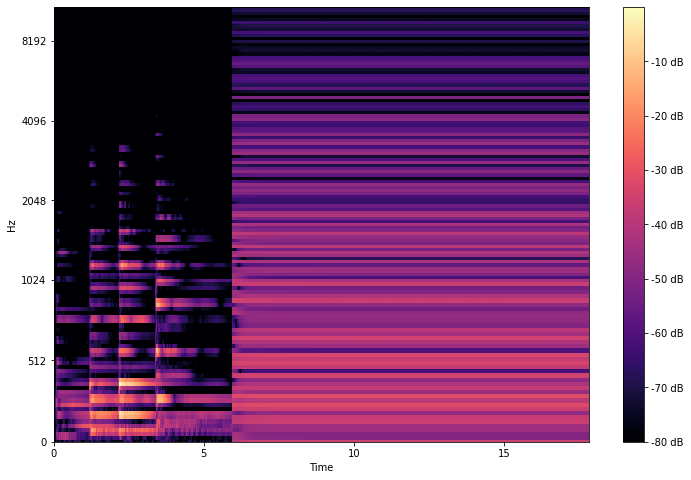

In [60]:
fig, ax = plt.subplots(figsize=(12,8))
melspec_db = librosa.amplitude_to_db(np.abs(seq.T), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
fig.savefig('lstm_melspec_epoch1.png')

In [69]:
def train_model(model, criterion, optimizer, num_epochs, batch_size, 
                melspec_path, sample_width, genres, max_samples):
    losses=[]
    
    sample_seq, sr = librosa.load('%s/piano.mp3' % data_path)
    #seq x dim
    sample_seq_melspec = librosa.feature.melspectrogram(sample_seq, sr=sr, n_mels=128, n_fft=2048, hop_length=512).T
    #clip to start of song length
    sample_seq_melspec = torch.from_numpy(sample_seq_melspec[:256,:])
    #add batch dim
    sample_seq_melspec = sample_seq_melspec.unsqueeze(0)
    
    for epoch in range(num_epochs):
        print('Epoch', epoch)
        ep_losses = []
        #state_h, state_c = model.init_state(batch_size)

        #sample width + 1 due to predicting 1 step ahead, separate into x and y
        samples = get_samples(melspec_path, sample_width+1, genres, max_samples)
        num_batches = math.ceil(len(samples)/batch_size)
        print('Samples: %d, Batches: %d' % (len(samples), num_batches))

        for batch in range(num_batches):
            if batch and batch%25==0:
                print('  Batch %d, Avg Epoch Loss: %.8f' % (batch, sum(ep_losses)/len(ep_losses)))

            #samples are (seq+1)xdim - stack batch samples, add empty channel dimension, [b, 128, 2049]
            x = torch.stack(samples[batch*batch_size:(batch+1)*batch_size]).to(device)
            if x.shape[0]<batch_size:
                continue
            x_batch = x[:, :sample_width, :]
            y_batch = x[:, 1:sample_width+1, :]

            #print('x', x_batch.size())

            optimizer.zero_grad()

            #y_pred, (state_h, state_c) = model(x_batch)#, (state_h, state_c))
            y_pred, _ = model(x_batch, model.init_state(batch_size))
            loss = criterion(y_pred, y_batch)
            ep_losses.append(loss.item())

            #state_h = state_h.detach()
            #state_c = state_c.detach()

            loss.backward()
            optimizer.step()

        print('saving model')
        torch.save(model.state_dict(), model_path)
        
        print('generating sample...')
        #seq x dim
        generated_melspec = predict(model, sample_seq_melspec)
        #dim x seq
        generated_melspec = generated_melspec.T
        
        fig, ax = plt.subplots(figsize=(12,8))
        melspec_db = librosa.amplitude_to_db(np.abs(generated_melspec), ref=np.max)
        img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        fig.savefig('lstm_melspec_epoch%d.png' % epoch)
        fig.clf()
        
        n_fft=2048
        n_iter=32
        sr=22050
        generated_melspec_audio = librosa.feature.inverse.mel_to_audio(generated_melspec, sr=sr, n_fft=n_fft, n_iter=n_iter)
        sf.write('lstm_melspec_audio_epoch%d.wav' % epoch, generated_melspec_audio, sr, 'PCM_24')
        
        losses.extend(ep_losses)
        
    return model, losses

In [67]:
sample_width = 2048
genres = ['classical']
max_samples = 50000
batch_size = 16
num_epochs = 100
in_dim, emb_dim, lstm_dim, num_layers = 128, 64, 64, 3

model = MusicLstm(in_dim, emb_dim, lstm_dim, num_layers)
model.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
model, losses = train_model(model, criterion, optimizer, num_epochs, batch_size, 
                            melspec_path, sample_width, genres, max_samples)

Epoch 0
Samples: 40498, Batches: 2532
  Batch 25, Avg Epoch Loss: 1528.59512695
  Batch 50, Avg Epoch Loss: 1534.78292236
  Batch 75, Avg Epoch Loss: 1438.29610758
  Batch 100, Avg Epoch Loss: 1427.26359924
  Batch 125, Avg Epoch Loss: 1395.33905591
  Batch 150, Avg Epoch Loss: 1418.26164327
  Batch 175, Avg Epoch Loss: 1424.18844709
  Batch 200, Avg Epoch Loss: 1414.74756241
  Batch 225, Avg Epoch Loss: 1413.72691962
  Batch 250, Avg Epoch Loss: 1404.81584656
  Batch 275, Avg Epoch Loss: 1412.84050926
  Batch 300, Avg Epoch Loss: 1427.28458079
  Batch 325, Avg Epoch Loss: 1417.16444965
  Batch 350, Avg Epoch Loss: 1414.53239842
  Batch 375, Avg Epoch Loss: 1415.07168726
  Batch 400, Avg Epoch Loss: 1408.43916878
  Batch 425, Avg Epoch Loss: 1405.46990845
  Batch 450, Avg Epoch Loss: 1402.43137431
  Batch 475, Avg Epoch Loss: 1400.66080727
  Batch 500, Avg Epoch Loss: 1403.24279279
  Batch 525, Avg Epoch Loss: 1402.61515840
  Batch 550, Avg Epoch Loss: 1394.14802507
  Batch 575, Avg Ep

  Batch 2200, Avg Epoch Loss: 867.06945137
  Batch 2225, Avg Epoch Loss: 866.04020038
  Batch 2250, Avg Epoch Loss: 864.85469639
  Batch 2275, Avg Epoch Loss: 863.31883842
  Batch 2300, Avg Epoch Loss: 862.89343344
  Batch 2325, Avg Epoch Loss: 861.88396642
  Batch 2350, Avg Epoch Loss: 860.69419814
  Batch 2375, Avg Epoch Loss: 859.93522985
  Batch 2400, Avg Epoch Loss: 858.22537945
  Batch 2425, Avg Epoch Loss: 858.19470557
  Batch 2450, Avg Epoch Loss: 857.87813468
  Batch 2475, Avg Epoch Loss: 857.18615810
  Batch 2500, Avg Epoch Loss: 856.56043773
  Batch 2525, Avg Epoch Loss: 855.26975747
  Batch 2550, Avg Epoch Loss: 854.33650312
  Batch 2575, Avg Epoch Loss: 853.90117423
  Batch 2600, Avg Epoch Loss: 852.23155565
  Batch 2625, Avg Epoch Loss: 851.61010064
  Batch 2650, Avg Epoch Loss: 851.37367884
  Batch 2675, Avg Epoch Loss: 851.42989222
  Batch 2700, Avg Epoch Loss: 850.64239327
  Batch 2725, Avg Epoch Loss: 850.64673131
  Batch 2750, Avg Epoch Loss: 850.39065771
  Batch 277

  Batch 1275, Avg Epoch Loss: 792.45227243
  Batch 1300, Avg Epoch Loss: 790.47204386
  Batch 1325, Avg Epoch Loss: 789.43285008
  Batch 1350, Avg Epoch Loss: 787.37503038
  Batch 1375, Avg Epoch Loss: 785.62729823
  Batch 1400, Avg Epoch Loss: 783.29510714
  Batch 1425, Avg Epoch Loss: 783.22808303
  Batch 1450, Avg Epoch Loss: 783.03105257
  Batch 1475, Avg Epoch Loss: 782.52638704
  Batch 1500, Avg Epoch Loss: 782.40003470
  Batch 1525, Avg Epoch Loss: 781.26545446
  Batch 1550, Avg Epoch Loss: 778.82881117
  Batch 1575, Avg Epoch Loss: 778.61679869
  Batch 1600, Avg Epoch Loss: 777.42203260
  Batch 1625, Avg Epoch Loss: 777.29165361
  Batch 1650, Avg Epoch Loss: 779.62399760
  Batch 1675, Avg Epoch Loss: 780.04795445
  Batch 1700, Avg Epoch Loss: 779.40565001
  Batch 1725, Avg Epoch Loss: 778.18939293
  Batch 1750, Avg Epoch Loss: 777.93426504
  Batch 1775, Avg Epoch Loss: 776.64376967
  Batch 1800, Avg Epoch Loss: 775.75164195
  Batch 1825, Avg Epoch Loss: 775.65952654
  Batch 185

  Batch 150, Avg Epoch Loss: 184.94550898
  Batch 175, Avg Epoch Loss: 183.10163611
  Batch 200, Avg Epoch Loss: 182.20224445
  Batch 225, Avg Epoch Loss: 181.08334525
  Batch 250, Avg Epoch Loss: 182.10737149
  Batch 275, Avg Epoch Loss: 178.90535735
  Batch 300, Avg Epoch Loss: 174.58651566
  Batch 325, Avg Epoch Loss: 175.81818963
  Batch 350, Avg Epoch Loss: 177.68148156
  Batch 375, Avg Epoch Loss: 176.85189428
  Batch 400, Avg Epoch Loss: 175.14867000
  Batch 425, Avg Epoch Loss: 175.48339995
  Batch 450, Avg Epoch Loss: 175.93855244
  Batch 475, Avg Epoch Loss: 175.08875646
  Batch 500, Avg Epoch Loss: 174.42668665
  Batch 525, Avg Epoch Loss: 174.20691616
  Batch 550, Avg Epoch Loss: 175.29803435
  Batch 575, Avg Epoch Loss: 175.17927460
  Batch 600, Avg Epoch Loss: 175.09353748
  Batch 625, Avg Epoch Loss: 174.17603001
  Batch 650, Avg Epoch Loss: 174.56876242
  Batch 675, Avg Epoch Loss: 174.32732695
  Batch 700, Avg Epoch Loss: 173.37284430
  Batch 725, Avg Epoch Loss: 173.9

  Batch 1975, Avg Epoch Loss: 245.40320689
  Batch 2000, Avg Epoch Loss: 245.13939697
  Batch 2025, Avg Epoch Loss: 244.69130902
  Batch 2050, Avg Epoch Loss: 244.33437287
  Batch 2075, Avg Epoch Loss: 244.20765560
  Batch 2100, Avg Epoch Loss: 243.98670228
  Batch 2125, Avg Epoch Loss: 243.15831969
  Batch 2150, Avg Epoch Loss: 242.96441990
  Batch 2175, Avg Epoch Loss: 242.25882731
  Batch 2200, Avg Epoch Loss: 242.13254479
  Batch 2225, Avg Epoch Loss: 241.79410334
  Batch 2250, Avg Epoch Loss: 241.56926630
  Batch 2275, Avg Epoch Loss: 241.50993680
  Batch 2300, Avg Epoch Loss: 241.56437383
  Batch 2325, Avg Epoch Loss: 240.79156021
  Batch 2350, Avg Epoch Loss: 240.05672383
  Batch 2375, Avg Epoch Loss: 239.94991809
  Batch 2400, Avg Epoch Loss: 239.56789922
  Batch 2425, Avg Epoch Loss: 239.40936156
  Batch 2450, Avg Epoch Loss: 239.48063824
  Batch 2475, Avg Epoch Loss: 238.98708974
  Batch 2500, Avg Epoch Loss: 239.02926817
  Batch 2525, Avg Epoch Loss: 238.74300955
  Batch 255

  Batch 1225, Avg Epoch Loss: 569.34017729
  Batch 1250, Avg Epoch Loss: 567.36464586
  Batch 1275, Avg Epoch Loss: 569.46967933
  Batch 1300, Avg Epoch Loss: 571.07681472
  Batch 1325, Avg Epoch Loss: 573.00749923
  Batch 1350, Avg Epoch Loss: 572.34780916
  Batch 1375, Avg Epoch Loss: 571.46609296
  Batch 1400, Avg Epoch Loss: 571.57230110
  Batch 1425, Avg Epoch Loss: 571.32903962
  Batch 1450, Avg Epoch Loss: 569.84901188
  Batch 1475, Avg Epoch Loss: 569.23064538
  Batch 1500, Avg Epoch Loss: 568.13094370
  Batch 1525, Avg Epoch Loss: 567.25072628
  Batch 1550, Avg Epoch Loss: 566.68061195
  Batch 1575, Avg Epoch Loss: 566.83592953
  Batch 1600, Avg Epoch Loss: 566.84302416
  Batch 1625, Avg Epoch Loss: 565.48809499
  Batch 1650, Avg Epoch Loss: 564.83374051
  Batch 1675, Avg Epoch Loss: 563.64654125
  Batch 1700, Avg Epoch Loss: 564.18988162
  Batch 1725, Avg Epoch Loss: 563.45853893
  Batch 1750, Avg Epoch Loss: 564.99682560
  Batch 1775, Avg Epoch Loss: 565.35312191
  Batch 180

  Batch 3050, Avg Epoch Loss: 2948.87022293
  Batch 3075, Avg Epoch Loss: 2950.25800397
  Batch 3100, Avg Epoch Loss: 2954.81855679
saving model
generating sample...
Epoch 10
Samples: 43468, Batches: 2717
  Batch 25, Avg Epoch Loss: 517.33038879
  Batch 50, Avg Epoch Loss: 526.30131317
  Batch 75, Avg Epoch Loss: 534.27668467
  Batch 100, Avg Epoch Loss: 543.33489891
  Batch 125, Avg Epoch Loss: 556.01746967
  Batch 150, Avg Epoch Loss: 576.34559097
  Batch 175, Avg Epoch Loss: 568.22182177
  Batch 200, Avg Epoch Loss: 548.30229122
  Batch 225, Avg Epoch Loss: 557.20734792
  Batch 250, Avg Epoch Loss: 547.50213303
  Batch 275, Avg Epoch Loss: 553.12325267
  Batch 300, Avg Epoch Loss: 553.94519730
  Batch 325, Avg Epoch Loss: 548.33023292
  Batch 350, Avg Epoch Loss: 551.25148717
  Batch 375, Avg Epoch Loss: 552.59244507
  Batch 400, Avg Epoch Loss: 548.07232773
  Batch 425, Avg Epoch Loss: 546.96332117
  Batch 450, Avg Epoch Loss: 545.16288598
  Batch 475, Avg Epoch Loss: 544.71338014


  Batch 2000, Avg Epoch Loss: 114.76058929
  Batch 2025, Avg Epoch Loss: 114.43203465
  Batch 2050, Avg Epoch Loss: 114.39793407
  Batch 2075, Avg Epoch Loss: 114.31197519
  Batch 2100, Avg Epoch Loss: 114.17118695
  Batch 2125, Avg Epoch Loss: 114.13185461
  Batch 2150, Avg Epoch Loss: 113.98599769
  Batch 2175, Avg Epoch Loss: 114.03004010
  Batch 2200, Avg Epoch Loss: 114.02057005
  Batch 2225, Avg Epoch Loss: 113.99035914
  Batch 2250, Avg Epoch Loss: 113.89212551
  Batch 2275, Avg Epoch Loss: 113.67442634
  Batch 2300, Avg Epoch Loss: 113.41500636
  Batch 2325, Avg Epoch Loss: 113.34219593
  Batch 2350, Avg Epoch Loss: 113.22023036
  Batch 2375, Avg Epoch Loss: 113.09032451
  Batch 2400, Avg Epoch Loss: 112.86056837
  Batch 2425, Avg Epoch Loss: 112.77895716
  Batch 2450, Avg Epoch Loss: 112.80167846
  Batch 2475, Avg Epoch Loss: 112.74125173
  Batch 2500, Avg Epoch Loss: 112.69113573
  Batch 2525, Avg Epoch Loss: 112.54261761
  Batch 2550, Avg Epoch Loss: 112.41778937
  Batch 257

  Batch 825, Avg Epoch Loss: 11938.85335205
  Batch 850, Avg Epoch Loss: 11977.88200926
  Batch 875, Avg Epoch Loss: 12031.72552923
  Batch 900, Avg Epoch Loss: 12020.36803719
  Batch 925, Avg Epoch Loss: 11995.61529135
  Batch 950, Avg Epoch Loss: 12103.72026740
  Batch 975, Avg Epoch Loss: 12017.39699155
  Batch 1000, Avg Epoch Loss: 11965.04761120
  Batch 1025, Avg Epoch Loss: 11992.78765736
  Batch 1050, Avg Epoch Loss: 12025.07066331
  Batch 1075, Avg Epoch Loss: 12009.77437053
  Batch 1100, Avg Epoch Loss: 11982.41444487
  Batch 1125, Avg Epoch Loss: 11923.97164336
  Batch 1150, Avg Epoch Loss: 11912.33242343
  Batch 1175, Avg Epoch Loss: 11922.51721439
  Batch 1200, Avg Epoch Loss: 11862.03602813
  Batch 1225, Avg Epoch Loss: 11822.21967494
  Batch 1250, Avg Epoch Loss: 11791.15457265
  Batch 1275, Avg Epoch Loss: 11737.44680866
  Batch 1300, Avg Epoch Loss: 11723.98282324
  Batch 1325, Avg Epoch Loss: 11727.72269771
  Batch 1350, Avg Epoch Loss: 11785.59260263
  Batch 1375, Avg

  Batch 2525, Avg Epoch Loss: 152.36454868
  Batch 2550, Avg Epoch Loss: 152.10360402
  Batch 2575, Avg Epoch Loss: 151.92287584
  Batch 2600, Avg Epoch Loss: 151.78557895
  Batch 2625, Avg Epoch Loss: 151.81250438
  Batch 2650, Avg Epoch Loss: 151.67348711
  Batch 2675, Avg Epoch Loss: 151.46352593
  Batch 2700, Avg Epoch Loss: 151.31881765
  Batch 2725, Avg Epoch Loss: 151.16924581
  Batch 2750, Avg Epoch Loss: 151.00316718
  Batch 2775, Avg Epoch Loss: 150.83673841
saving model
generating sample...
Epoch 15
Samples: 46898, Batches: 2932
  Batch 25, Avg Epoch Loss: 126.50206863
  Batch 50, Avg Epoch Loss: 116.62764956
  Batch 75, Avg Epoch Loss: 111.51346399
  Batch 100, Avg Epoch Loss: 100.29853842
  Batch 125, Avg Epoch Loss: 101.36629082
  Batch 150, Avg Epoch Loss: 100.61215019
  Batch 175, Avg Epoch Loss: 97.55963450
  Batch 200, Avg Epoch Loss: 94.57303447
  Batch 225, Avg Epoch Loss: 95.23981469
  Batch 250, Avg Epoch Loss: 95.51830883
  Batch 275, Avg Epoch Loss: 94.57741474


  Batch 1600, Avg Epoch Loss: 1090.00876339
  Batch 1625, Avg Epoch Loss: 1091.11561518
  Batch 1650, Avg Epoch Loss: 1093.01264501
  Batch 1675, Avg Epoch Loss: 1095.83788924
  Batch 1700, Avg Epoch Loss: 1094.93471113
  Batch 1725, Avg Epoch Loss: 1095.31194392
  Batch 1750, Avg Epoch Loss: 1090.82777404
  Batch 1775, Avg Epoch Loss: 1085.12224438
  Batch 1800, Avg Epoch Loss: 1083.23280595
  Batch 1825, Avg Epoch Loss: 1077.33602683
  Batch 1850, Avg Epoch Loss: 1080.12629487
  Batch 1875, Avg Epoch Loss: 1078.41016984
  Batch 1900, Avg Epoch Loss: 1074.82884228
  Batch 1925, Avg Epoch Loss: 1069.28280697
  Batch 1950, Avg Epoch Loss: 1070.85505445
  Batch 1975, Avg Epoch Loss: 1068.08811602
  Batch 2000, Avg Epoch Loss: 1064.41287026
  Batch 2025, Avg Epoch Loss: 1061.71582548
  Batch 2050, Avg Epoch Loss: 1065.65912076
  Batch 2075, Avg Epoch Loss: 1061.39676137
  Batch 2100, Avg Epoch Loss: 1061.72919198
  Batch 2125, Avg Epoch Loss: 1061.95330521
  Batch 2150, Avg Epoch Loss: 10

  Batch 800, Avg Epoch Loss: 1142.96918199
  Batch 825, Avg Epoch Loss: 1149.23376516
  Batch 850, Avg Epoch Loss: 1157.35992681
  Batch 875, Avg Epoch Loss: 1153.92869020
  Batch 900, Avg Epoch Loss: 1150.44286017
  Batch 925, Avg Epoch Loss: 1145.22661623
  Batch 950, Avg Epoch Loss: 1152.61708954
  Batch 975, Avg Epoch Loss: 1167.22523969
  Batch 1000, Avg Epoch Loss: 1165.06538524
  Batch 1025, Avg Epoch Loss: 1163.29183361
  Batch 1050, Avg Epoch Loss: 1165.07768028
  Batch 1075, Avg Epoch Loss: 1158.89271852
  Batch 1100, Avg Epoch Loss: 1165.15631944
  Batch 1125, Avg Epoch Loss: 1163.66357077
  Batch 1150, Avg Epoch Loss: 1157.42268444
  Batch 1175, Avg Epoch Loss: 1155.43411250
  Batch 1200, Avg Epoch Loss: 1151.49067908
  Batch 1225, Avg Epoch Loss: 1150.81560950
  Batch 1250, Avg Epoch Loss: 1148.86119764
  Batch 1275, Avg Epoch Loss: 1145.97504726
  Batch 1300, Avg Epoch Loss: 1145.53285160
  Batch 1325, Avg Epoch Loss: 1149.01559239
  Batch 1350, Avg Epoch Loss: 1148.72312

  Batch 2675, Avg Epoch Loss: 161.64680864
  Batch 2700, Avg Epoch Loss: 161.28214912
  Batch 2725, Avg Epoch Loss: 161.05546381
  Batch 2750, Avg Epoch Loss: 160.87692037
  Batch 2775, Avg Epoch Loss: 160.63526210
  Batch 2800, Avg Epoch Loss: 160.46038602
  Batch 2825, Avg Epoch Loss: 160.21029760
  Batch 2850, Avg Epoch Loss: 160.06045673
  Batch 2875, Avg Epoch Loss: 159.78457719
  Batch 2900, Avg Epoch Loss: 159.51546087
  Batch 2925, Avg Epoch Loss: 159.30765734
  Batch 2950, Avg Epoch Loss: 158.93947334
  Batch 2975, Avg Epoch Loss: 158.92273147
  Batch 3000, Avg Epoch Loss: 158.84556631
  Batch 3025, Avg Epoch Loss: 158.56649925
saving model
generating sample...
Epoch 20
Samples: 47493, Batches: 2969
  Batch 25, Avg Epoch Loss: 329.80295471
  Batch 50, Avg Epoch Loss: 333.02964653
  Batch 75, Avg Epoch Loss: 317.95869227
  Batch 100, Avg Epoch Loss: 310.76368084
  Batch 125, Avg Epoch Loss: 307.31799399
  Batch 150, Avg Epoch Loss: 297.40518293
  Batch 175, Avg Epoch Loss: 290.

<ipython-input-69-4ec01220663a>:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,8))


Epoch 21
Samples: 44619, Batches: 2789
  Batch 25, Avg Epoch Loss: 401.27985962
  Batch 50, Avg Epoch Loss: 347.98269508
  Batch 75, Avg Epoch Loss: 344.53497564
  Batch 100, Avg Epoch Loss: 336.60489040
  Batch 125, Avg Epoch Loss: 326.47222781
  Batch 150, Avg Epoch Loss: 321.24559334
  Batch 175, Avg Epoch Loss: 308.39590088
  Batch 200, Avg Epoch Loss: 314.79828903
  Batch 225, Avg Epoch Loss: 316.00878791
  Batch 250, Avg Epoch Loss: 310.85652655
  Batch 275, Avg Epoch Loss: 306.35241587
  Batch 300, Avg Epoch Loss: 302.21828569
  Batch 325, Avg Epoch Loss: 299.21700382
  Batch 350, Avg Epoch Loss: 298.12859806
  Batch 375, Avg Epoch Loss: 296.97505228
  Batch 400, Avg Epoch Loss: 295.39942798
  Batch 425, Avg Epoch Loss: 296.34025558
  Batch 450, Avg Epoch Loss: 295.18120874
  Batch 475, Avg Epoch Loss: 294.21202964
  Batch 500, Avg Epoch Loss: 291.65633053
  Batch 525, Avg Epoch Loss: 292.22529623
  Batch 550, Avg Epoch Loss: 290.86568775
  Batch 575, Avg Epoch Loss: 289.5438409

KeyboardInterrupt: 

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

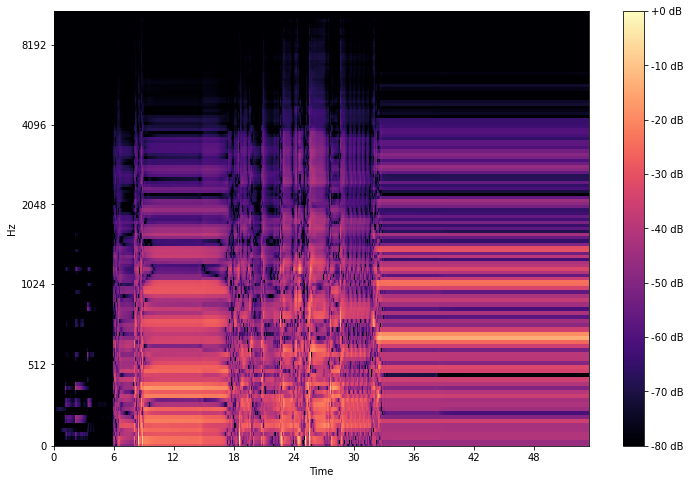

In [64]:
generated_melspec = predict(model, sample_seq_melspec)
#dim x seq
generated_melspec = generated_melspec.T

fig, ax = plt.subplots(figsize=(12,8))
melspec_db = librosa.amplitude_to_db(np.abs(generated_melspec), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
#fig.savefig('lstm_melspec_epoch1.png')

In [65]:
fig.clf()

In [7]:
x, sr = librosa.load('%s/piano.mp3' % data_path)
x_melspec = librosa.feature.melspectrogram(x, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
print(x_melspec.shape)
seq = torch.from_numpy(x_melspec.T)
last_item_logits = torch.ones((1,1,128))
s = torch.cat((seq[:256,:].unsqueeze(0), last_item_logits), axis=1)
s.size()

c:\ml\env\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(128, 2428)